Auto scoring for fields with exact match

In [19]:
import json

def score_files(llm_output_path, source_of_truth_path):
    """
    Compares specified fields between LLM output and source of truth JSON files
    and calculates a score.

    Args:
        llm_output_path (str): Path to the LLM output JSON file.
        source_of_truth_path (str): Path to the source of truth JSON file.

    Returns:
        float: The calculated score for the specified fields.
    """
    total_score = 0
    max_possible_score = 0

    try:
        with open(llm_output_path, 'r') as f:
            llm_data = json.load(f)
            # Handle cases where the top-level is a list with a single dictionary
            if isinstance(llm_data, list) and len(llm_data) > 0:
                llm_data = llm_data[0]

        with open(source_of_truth_path, 'r') as f:
            source_data = json.load(f)
            # Handle cases where the top-level is a list with a single dictionary
            if isinstance(source_data, list) and len(source_data) > 0:
                source_data = source_data[0]

    except FileNotFoundError:
        print("Error: One or both files not found.")
        return 0
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from one or both files.")
        return 0
    except KeyError as e:
        print(f"Error: Missing expected key in JSON data: {e}. Please check file structure.")
        return 0

    print(f"--- Scoring Comparison for {llm_output_path} vs {source_of_truth_path} ---")

    # 1. Compare ad_number (5 points)
    max_possible_score += 5
    llm_ad_number = llm_data.get('ad_number')
    source_ad_number = source_data.get('ad_number')
    if llm_ad_number == source_ad_number:
        total_score += 5
        print(f"ad_number: MATCH! ('{llm_ad_number}') - +5 points")
    else:
        print(f"ad_number: MISMATCH! LLM: '{llm_ad_number}', Source: '{source_ad_number}' - +0 points")

    # 2. Compare status (5 points)
    max_possible_score += 5
    llm_status = llm_data.get('status')
    source_status = source_data.get('status')
    if llm_status == source_status:
        total_score += 5
        print(f"status: MATCH! ('{llm_status}') - +5 points")
    else:
        print(f"status: MISMATCH! LLM: '{llm_status}', Source: '{source_status}' - +0 points")

    # 3. Compare ata_number (5 points)
    max_possible_score += 5
    llm_ata_number = llm_data.get('ata_number')
    source_ata_number = source_data.get('ata_number')
    if llm_ata_number == source_ata_number:
        total_score += 5
        print(f"ata_number: MATCH! ('{llm_ata_number}') - +5 points")
    else:
        print(f"ata_number: MISMATCH! LLM: '{llm_ata_number}', Source: '{source_ata_number}' - +0 points")

    # 4. Compare models (20 points, with partial credit)
    max_possible_score += 20
    llm_models = []
    source_models = []

    # Safely access models list
    if 'applicability_groups' in llm_data and llm_data['applicability_groups']:
        llm_models = llm_data['applicability_groups'][0].get('models', [])
    if 'applicability_groups' in source_data and source_data['applicability_groups']:
        source_models = source_data['applicability_groups'][0].get('models', [])

    llm_models_set = set(llm_models)
    source_models_set = set(source_models)

    if not source_models_set:
        print("models: Source of truth 'models' list is empty. Cannot score.")
        models_score = 0
    elif llm_models_set == source_models_set:
        models_score = 20
        print(f"models: EXACT MATCH! All models are correct. - +{models_score} points")
    else:
        common_models = len(llm_models_set.intersection(source_models_set))
        # Use the length of the source models set for the denominator for accuracy
        models_score = (common_models / len(source_models_set)) * 20
        print(f"models: PARTIAL MATCH! Common models: {common_models}/{len(source_models_set)}")
        print(f"models: Missing in LLM: {list(source_models_set - llm_models_set)}")
        print(f"models: Extra in LLM: {list(llm_models_set - source_models_set)}")
        print(f"models: - +{models_score:.2f} points")

    total_score += models_score

    print(f"\nTotal Automatic Score: {total_score:.2f} / {max_possible_score}")
    return total_score

# Example Usage (replace with your file paths):
llm_file = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\golden_data_llm_with\LWG_experoment\output_structured\AD_2022-0115_2_ocr_lwg.json'
source_file = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\golden_data_llm_with\AD_2022-0115_2_c.json'

score = score_files(llm_file, source_file)
print(f"\nFinal Score for {llm_file}: {score:.2f}")

--- Scoring Comparison for C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\golden_data_llm_with\LWG_experoment\output_structured\AD_2022-0115_2_ocr_lwg.json vs C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\golden_data_llm_with\AD_2022-0115_2_c.json ---
ad_number: MATCH! ('2022-0115') - +5 points
status: MISMATCH! LLM: 'superseded', Source: 'active' - +0 points
ata_number: MATCH! ('ATA 53') - +5 points
models: PARTIAL MATCH! Common models: 8/8
models: Missing in LLM: []
models: Extra in LLM: ['A321-112', 'A320-214', 'A320-215', 'A321-232', 'A321-213', 'A321-211', 'A321-111', 'A320-216', 'A321-131', 'A320-231', 'A321-231', 'A320-212', 'A320-233', 'A320-211', 'A320-232', 'A321-212']
models: - +20.00 points

Total Automatic Score: 30.00 / 35

Final Score for C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\golden_data_llm_with\LWG_e

metrics for time processing

Scanning for OCR files in: C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\llm_with_guidance_dataset\ocr_output
Scanning for structured files in: C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\llm_with_guidance_dataset\ocr_output\output_structured

--- Processing Files ---
Skipping AD_2020-0274_1: No structured file found matching '_ocr_lwg.json' pattern.
Skipping AD_2022-0026_2: No structured file found matching '_ocr_lwg.json' pattern.

--- Analysis Complete for 98 matching AD pairs ---

--- Raw Data ---
           AD_Number  OCR_Processing_Time  LLM_Structuring_Time  \
0   AD_2018-0289R1_1                10.03                  8.95   
1     AD_2019-0005_1                 7.56                  1.81   
2   AD_2019-0035R1_1                 7.58                  4.00   
3     AD_2019-0056_1                 8.66                  3.60   
4   AD_2019-0067R1_1                 7.67     

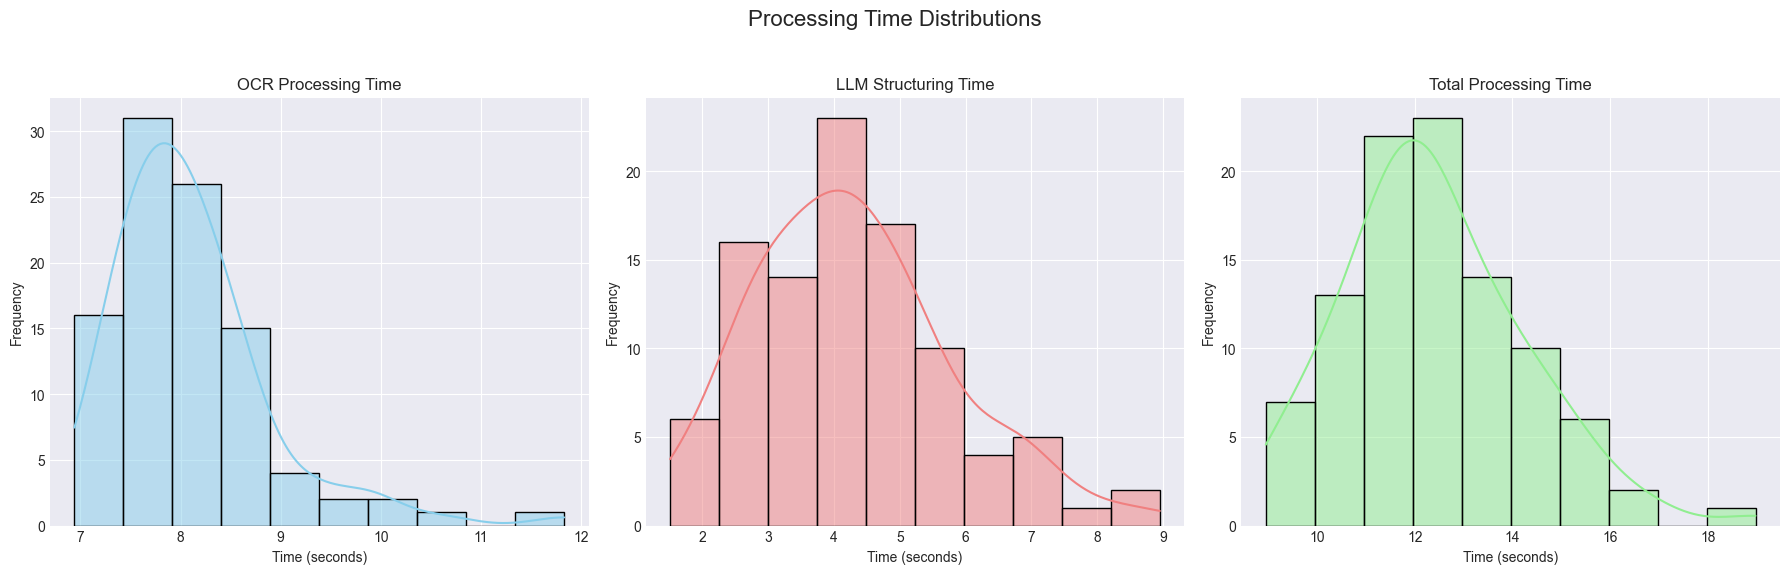


--- Processing Time Ratios ---
Average ratio of OCR Processing Time to Total: 66.27%
Average ratio of LLM Structuring Time to Total: 33.73%


In [24]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_processing_times_all_files(ocr_base_path, structured_base_path):
    """
    Analyzes OCR and LLM structuring processing times for all matching files
    found in the specified directories.

    Args:
        ocr_base_path (str): The base directory where Document AI OCR output JSON files are located.
        structured_base_path (str): The base directory where LLM structured output JSON files are located.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted processing times.
    """

    ad_files_map = {}

    # --- Discover OCR Output Files ---
    print(f"Scanning for OCR files in: {ocr_base_path}")
    for filename in os.listdir(ocr_base_path):
        # Expected OCR file name: AD_XXXX_ocr.json
        if filename.endswith('_ocr.json'):
            # Extract AD ID by removing '_ocr.json'
            ad_id = filename.replace('_ocr.json', '')
            if ad_id not in ad_files_map:
                ad_files_map[ad_id] = {}
            ad_files_map[ad_id]['ocr_file'] = os.path.join(ocr_base_path, filename)

    # --- Discover Structured Output Files ---
    print(f"Scanning for structured files in: {structured_base_path}")
    for filename in os.listdir(structured_base_path):
        # Expected structured file name: AD_XXXX_ocr_lwg.json
        if filename.endswith('_ocr_lwg.json'):
            # Extract AD ID by removing '_ocr_lwg.json'
            ad_id = filename.replace('_ocr_lwg.json', '')
            if ad_id not in ad_files_map:
                ad_files_map[ad_id] = {}
            ad_files_map[ad_id]['structured_file'] = os.path.join(structured_base_path, filename)
        # No generic .json check here, relying strictly on the _ocr_lwg.json suffix for structured files.


    results = []
    processed_count = 0

    print("\n--- Processing Files ---")
    for ad_id, file_paths in ad_files_map.items():
        ocr_time = None
        structure_time = None
        
        ocr_file_path = file_paths.get('ocr_file')
        structured_file_path = file_paths.get('structured_file')

        if not ocr_file_path:
            print(f"Skipping {ad_id}: No OCR file found matching '_ocr.json' pattern.")
            continue
        if not structured_file_path:
            print(f"Skipping {ad_id}: No structured file found matching '_ocr_lwg.json' pattern.")
            continue
        
        processed_count += 1
        # print(f"Processing {ad_id}...") # Uncomment for detailed processing logs

        # --- Extract OCR Processing Time ---
        try:
            with open(ocr_file_path, 'r', encoding='utf-8') as f:
                ocr_data = json.load(f)
                ocr_time = ocr_data.get('ocr_processing_time')
        except FileNotFoundError:
            print(f"Error: OCR file not found for {ad_id} at {ocr_file_path}")
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from OCR file for {ad_id} at {ocr_file_path}")
        except Exception as e:
            print(f"Error: An error occurred reading OCR file for {ad_id}: {e}")

        # --- Extract LLM Structuring Processing Time ---
        try:
            with open(structured_file_path, 'r', encoding='utf-8') as f:
                structured_data = json.load(f)
                # Handle cases where the top-level is a list with a single dictionary
                if isinstance(structured_data, list) and len(structured_data) > 0:
                    structured_data = structured_data[0]
                structure_time = structured_data.get('structure_processing_time')
        except FileNotFoundError:
            print(f"Error: Structured file not found for {ad_id} at {structured_file_path}")
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from structured file for {ad_id} at {structured_file_path}")
        except Exception as e:
            print(f"Error: An error occurred reading structured file for {ad_id}: {e}")

        results.append({
            'AD_Number': ad_id,
            'OCR_Processing_Time': ocr_time,
            'LLM_Structuring_Time': structure_time
        })

    if not results:
        print("\nNo matching AD file pairs found for analysis. Please check your directory paths and file naming conventions.")
        print("Expected OCR pattern: AD_XXXX_ocr.json")
        print("Expected Structured pattern: AD_XXXX_ocr_lwg.json")
        return pd.DataFrame() # Return empty DataFrame if no results

    df = pd.DataFrame(results)

    # Calculate Total Processing Time, handling missing values gracefully
    df['Total_Processing_Time'] = df['OCR_Processing_Time'].fillna(0) + df['LLM_Structuring_Time'].fillna(0)

    # Convert columns to numeric, coercing errors to NaN
    df['OCR_Processing_Time'] = pd.to_numeric(df['OCR_Processing_Time'], errors='coerce')
    df['LLM_Structuring_Time'] = pd.to_numeric(df['LLM_Structuring_Time'], errors='coerce')
    df['Total_Processing_Time'] = pd.to_numeric(df['Total_Processing_Time'], errors='coerce')

    print(f"\n--- Analysis Complete for {processed_count} matching AD pairs ---")
    print("\n--- Raw Data ---")
    print(df)

    print("\n--- Statistical Summary ---")
    print("\nOCR Processing Time:")
    print(df['OCR_Processing_Time'].describe())

    print("\nLLM Structuring Time:")
    print(df['LLM_Structuring_Time'].describe())

    print("\nTotal Processing Time (OCR + LLM Structuring):")
    print(df['Total_Processing_Time'].describe())

    # --- Plotting Histograms ---
    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style for plots

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Processing Time Distributions', fontsize=16)

    # Ensure plots only include valid numeric data
    sns.histplot(df['OCR_Processing_Time'].dropna(), kde=True, ax=axes[0], color='skyblue', bins=10)
    axes[0].set_title('OCR Processing Time')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Frequency')

    sns.histplot(df['LLM_Structuring_Time'].dropna(), kde=True, ax=axes[1], color='lightcoral', bins=10)
    axes[1].set_title('LLM Structuring Time')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Frequency')

    sns.histplot(df['Total_Processing_Time'].dropna(), kde=True, ax=axes[2], color='lightgreen', bins=10)
    axes[2].set_title('Total Processing Time')
    axes[2].set_xlabel('Time (seconds)')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    return df

def calculate_and_print_ratios(df):
    """
    Calculates and prints the average ratio of OCR and LLM structuring time
    to the total processing time.

    Args:
        df (pandas.DataFrame): DataFrame containing 'OCR_Processing_Time',
                               'LLM_Structuring_Time', and 'Total_Processing_Time' columns.
    """
    print("\n--- Processing Time Ratios ---")

    # Filter out rows where total processing time is zero or NaN to avoid division by zero
    valid_df = df[df['Total_Processing_Time'] > 0].copy()

    if valid_df.empty:
        print("No valid data to calculate ratios (Total Processing Time is 0 or NaN for any entries).")
        return

    valid_df['OCR_Time_Ratio'] = valid_df['OCR_Processing_Time'] / valid_df['Total_Processing_Time']
    valid_df['LLM_Time_Ratio'] = valid_df['LLM_Structuring_Time'] / valid_df['Total_Processing_Time']

    avg_ocr_ratio = valid_df['OCR_Time_Ratio'].mean()
    avg_llm_ratio = valid_df['LLM_Time_Ratio'].mean()

    print(f"Average ratio of OCR Processing Time to Total: {avg_ocr_ratio:.2%}")
    print(f"Average ratio of LLM Structuring Time to Total: {avg_llm_ratio:.2%}")

# --- Configuration ---
# IMPORTANT: Update these paths to match your local directories
ocr_output_base_directory = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\llm_with_guidance_dataset\ocr_output'
# Corrected the path for structured output based on previous conversations.
structured_output_base_directory = r'C:\Users\zdrop\OneDrive - TU Wien\MASTER THESIS\ADs\A320\directives\sample dataset\llm_with_guidance\llm_with_guidance_dataset\ocr_output\output_structured'

# --- Run the analysis ---
if __name__ == "__main__":
    processing_times_df = analyze_processing_times_all_files(
        ocr_output_base_directory,
        structured_output_base_directory
    )
    if not processing_times_df.empty:
        calculate_and_print_ratios(processing_times_df)